## TODO

In [647]:
import copy
import ipywidgets
import json
import kaolin
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchvision
from PIL import Image


# Gaussian splatting dependencies
from utils.graphics_utils import focal2fov
from utils.system_utils import searchForMaxIteration
from gaussian_renderer import render, GaussianModel
from scene.cameras import Camera as GSCamera

def log_tensor(t, name, **kwargs):
    print(kaolin.utils.testing.tensor_info(t, name=name, **kwargs))

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [648]:
class PipelineParamsNoparse:
    """ Same as PipelineParams but without argument parser. """
    def __init__(self):
        self.convert_SHs_python = False
        self.compute_cov3D_python = False
        self.debug = False
        self.antialiasing = True

dirname = os.getcwd()
filename = "point_cloud.ply"
filepath = os.path.join(dirname, filename)
gaussians = GaussianModel(3)
gaussians.load_ply(filepath) 
pipeline = PipelineParamsNoparse()
background = torch.tensor([0, 0, 0], dtype=torch.float32, device="cuda")
resolution = (800, 600)

# Dummy camera identifier (e.g. from COLMAP)
colmap_id = 0

# Rotation matrix R (here, the identity matrix)
R=np.array([[-9.9037e-01,  2.3305e-02, -1.3640e-01], [ 1.3838e-01,  1.6679e-01, -9.7623e-01], [-1.6444e-09, -9.8571e-01, -1.6841e-01]]) 

# Translation vector T (zero translation)
T=np.array([6.8159e-09, 2.0721e-10, 2])

# Field-of-view in degrees for the x and y directions
FoVx=0.69111120
FoVy=0.69111120

# Depth parameters (these are typically computed during preprocessing)
depth_params = {
    "scale": 1.0,
    "med_scale": 1.0,
    "offset": 0.0
}

# Create a dummy image.
# In a real application, you’d load an image (for example, via Image.open("path/to/image.jpg"))

# Create a PIL image of size (width, height) = (800, 600) with RGB mode.
image = Image.new("RGB", (800, 600), color="white")

# Create a dummy inverse-depth map as a 2D numpy array.
# Its shape should match (height, width) and contain valid depth values.
invdepthmap = np.ones((resolution[1], resolution[0]), dtype=np.float32)

# Provide an image name and a unique identifier (uid)
image_name = "dummy_image.jpg"
uid = "cam01"

# Optional parameters (using defaults for trans, scale, data_device, and testing flags)
trans = np.array([0.0, 0.0, 0.0])
scale = 1.0
data_device = "cuda"  # Change to "cpu" if you are not using CUDA
train_test_exp = False
is_test_dataset = False
is_test_view = False

# --- Instantiate the Gaussian Splat Camera ---

test_camera = GSCamera(
    resolution, 
    colmap_id, 
    R, 
    T, 
    FoVx, 
    FoVy, 
    depth_params, 
    image, 
    invdepthmap, 
    image_name, 
    uid,
    trans,
    scale,
    data_device,
    train_test_exp,
    is_test_dataset,
    is_test_view
)



render: [3, 600, 800] (torch.float32)[cuda:0]  - [min 0.0000, max 0.7313, mean 0.0582] 
viewspace_points: [17121, 3] (torch.float32)[cuda:0]  - [min 0.0000, max 0.0000, mean 0.0000] 
visibility_filter: [17121, 1] (torch.int64)[cuda:0]  - [min 0.0000, max 17120.0000, mean 8560.0000] 
radii: [17121] (torch.int32)[cuda:0]  - [min 3.0000, max 136.0000, mean 25.9674] 
depth: [1, 600, 800] (torch.float32)[cuda:0]  - [min 0.0000, max 0.6803, mean 0.0673] 


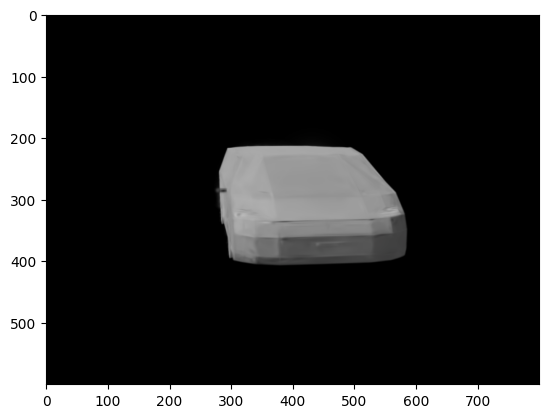

In [649]:
render_res = render(test_camera, gaussians, pipeline, background)
rendering = render_res["render"]
for k in render_res.keys():
    log_tensor(render_res[k], k, print_stats=True)
plt.imshow((rendering.permute(1, 2, 0) * 255).to(torch.uint8).detach().cpu().numpy())

# Calculating surface gaussians

In [650]:
import cupy as cp
from vispy import scene, app
import numpy as np
import cupy as cp
import os
import pandas as pd
from plyfile import PlyData
from math import pi
app.use_app('jupyter_rfb')
sigmoid = lambda x: 1 / (1 + cp.exp(-x))

## Raytracing logic

### Splats to bounding volumes

## Gaussian Model

In [717]:
print(app.use_app())
class Gaussians:
    def post_process(self):
        self.n_gaussians = self.opacities.shape[0]
         # pass opacities to a sigmoid

        self.normalised_quaternions = self.quaternions / cp.linalg.norm(self.quaternions, axis=1, keepdims=True)
        self.rotations = quaternion_to_rotation_matrix(self.normalised_quaternions)
        self.scales_exp = cp.exp(self.scales)
        self.scales_d = cp.eye(3)[None, :, :] * (self.scales_exp)[:, :, None]
        self.scales_d **= 2
        self.scales_i_d = cp.eye(3)[None, :, :] * (1/self.scales_exp)[:, :, None]
        self.scales_i_d **= 2

        self.rotations_t = cp.transpose(self.rotations, (0,2,1))
        self.scales_d_t = cp.transpose(self.scales_d, (0,2,1)) 

        # Calculate covariance
        self.covariances = self.rotations @ self.scales_d @ self.rotations_t
        self.inv_covariances = self.rotations @ self.scales_i_d @ self.rotations_t 

        self.opacities = sigmoid(self.opacities).reshape((self.n_gaussians, 1))
       
    
    def load_from_ply(self, path):
        ply = PlyData.read(path)
        vertex_data = ply["vertex"].data
        df = pd.DataFrame(vertex_data)


        
        means_mask = ["x", "y", "z"]
        quaternions_mask = ["rot_0", "rot_1", "rot_2", "rot_3"]
        scales_mask = ["scale_0", "scale_1", "scale_2"]
        opacities_mask = ["opacity"]

        self.means = cp.array(df[means_mask].values)
        self.quaternions = cp.array(df[quaternions_mask].values)
        self.scales = cp.array(df[scales_mask].values)
        self.opacities = cp.array(df[opacities_mask].values)
        self.post_process()

    def at(self, index=0):
        selected_gaussian = Gaussians(None)
        selected_gaussian.means = cp.array([self.means[index]])
        selected_gaussian.scales = cp.array([self.scales[index]])
        selected_gaussian.quaternions = cp.array([self.quaternions[index]])
        selected_gaussian.opacities = cp.array([self.opacities[index]])

        selected_gaussian.rotations = cp.array([self.rotations[index]])
        selected_gaussian.covariances = cp.array([self.covariances[index]])
        selected_gaussian.inv_covariances = cp.array([self.inv_covariances[index]])

     
        return selected_gaussian

        
    def __init__(self, path):
        self.means = None
        self.quaternions = None
        self.scales = None
        self.opacities = None
        
        self.solutions = None

        if path is not None:
            self.load_from_ply(path)
            


def quaternion_to_rotation_matrix(quaternions):
    x = quaternions[:, 1]
    y = quaternions[:, 2]
    z = quaternions[:, 3]
    w = quaternions[:, 0]

    xx = x * x
    yy = y * y
    zz = z * z
    xy = x * y
    xz = x * z
    yz = y * z
    xw = x * w
    yw = y * w
    zw = z * w

    n = quaternions.shape[0]
    R = cp.empty((n, 3, 3), dtype=quaternions.dtype)

    R[:, 0, 0] = 1 - 2 * (yy + zz)
    R[:, 0, 1] = 2 * (xy - zw)
    R[:, 0, 2] = 2 * (xz + yw)
    R[:, 1, 0] = 2 * (xy + zw)
    R[:, 1, 1] = 1 - 2 * (xx + zz)
    R[:, 1, 2] = 2 * (yz - xw)
    R[:, 2, 0] = 2 * (xz - yw)
    R[:, 2, 1] = 2 * (yz + xw)
    R[:, 2, 2] = 1 - 2 * (xx + yy)

    return R

def create_bounding_boxes(gaussians: Gaussians):
    unit_cube = cp.array(
        [
            [1.0, 1.0, 1.0],
            [1.0, 1.0, -1.0],
            [1.0, -1.0, 1.0],
            [1.0, -1.0, -1.0],
            [-1.0, 1.0, 1.0],
            [-1.0, 1.0, -1.0],
            [-1.0, -1.0, 1.0],
            [-1.0, -1.0, -1.0],
        ]
    )
    
    # Shape: (N, 8, 3)
    scaled_vertices = gaussians.scales_exp[:, None, :] * unit_cube[None, :, :]
    
    # Rotations: (N, 3, 3)
    # scaled_vertices.transpose(0, 2, 1): (N, 3, 8)
    # Multiply => (N, 3, 8)
    # Then transpose back => (N, 8, 3)
    rotated_vertices = (gaussians.rotations @ scaled_vertices.transpose(0, 2, 1)).transpose(0, 2, 1)

    # Finally translate by the means: shape (N, 3) => broadcast to (N, 8, 3)
    return rotated_vertices + gaussians.means[:, None, :]

gaussians = Gaussians("point_cloud.ply")
boxes = create_bounding_boxes(gaussians)

<Vispy app, wrapping the jupyter_rfb GUI toolkit>


## Verifying covariance calculations

In [652]:
def visualise_covariance_matrix(gaussians):
    selected_covariance = gaussians.at(0)
    

visualise_covariance_matrix(gaussians)

hell


## Bounding boxes visualisation

RFBOutputContext()

CanvasBackend(css_height='600px', css_width='800px')
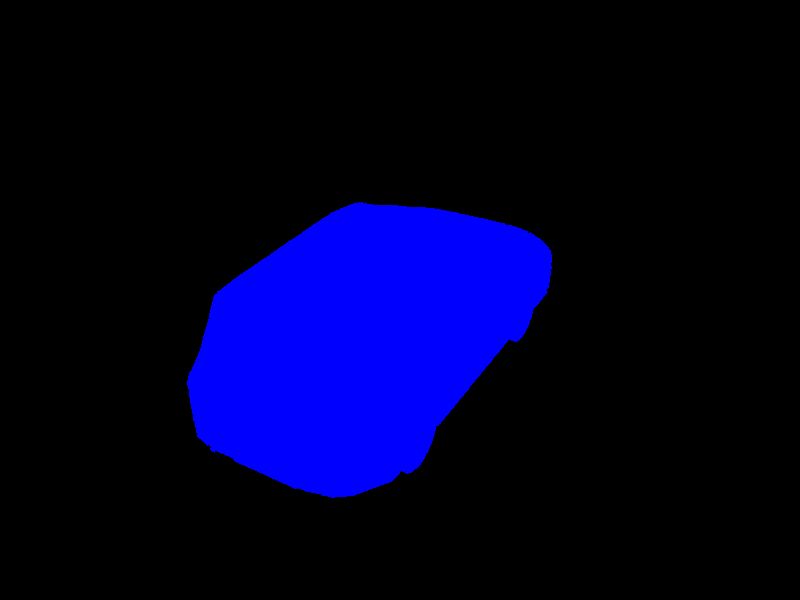

In [653]:
edges = np.array([
    [0, 1],
    [0, 2],
    [0, 4],
    [1, 3],
    [1, 5],
    [2, 3],
    [2, 6],
    [3, 7],
    [4, 5],
    [4, 6],
    [5, 7],
    [6, 7]
])

# Convert the CuPy array to a NumPy array for Vispy.
boxes_np = cp.asnumpy(boxes)  # shape (n, 8, 3)

# For each box, extract the vertices for its edges.
# boxes_np[:, edges, :] results in an array of shape (n, 12, 2, 3)
segments = boxes_np[:, edges, :]
# Reshape so that each segment (edge) is a separate element:
segments = segments.reshape(-1, 2, 3)  # shape (n*12, 2, 3)
# Flatten each segment pair into a contiguous list of vertices.
# With connect='segments', every pair of vertices is drawn as a separate line.
vertices = segments.reshape(-1, 3)  # shape (n*12*2, 3)

# --- Create a Vispy Scene and Draw the Lines ---
# Create a Vispy canvas.
canvas = scene.SceneCanvas(keys='interactive', show=True)
view = canvas.central_widget.add_view()

# Create a Line visual. The 'connect="segments"' setting means that every two
# consecutive vertices in 'vertices' are rendered as a separate line segment.
line_visual = scene.visuals.Line(pos=vertices, color='blue', width=2, connect='segments')
view.add(line_visual)

# Set a turntable camera for intuitive 3D navigation.
view.camera = 'turntable'
view.camera.fov = 45

# Optionally, add a grid or axes if desired:
# grid = scene.visuals.GridLines(color='gray')
# view.add(grid)

# Start the Vispy application event loop.

app.run()
from IPython.display import display
display(canvas.native)

## Ray generation logic - sphere

In [654]:
def generate_sphere_rays(center, radius, n):
    # Generate random angles for spherical coordinates
    theta = cp.random.rand(n, 1) * 2 * cp.pi  # Azimuthal angle
    phi = cp.random.rand(n, 1) * cp.pi        # Polar angle

    # Spherical to Cartesian conversion
    x = radius * cp.sin(phi) * cp.cos(theta)
    y = radius * cp.sin(phi) * cp.sin(theta)
    z = radius * cp.cos(phi)

    # Combine into ray origins
    ray_oris = cp.hstack((x, y, z))

    # Ray directions pointing outward from the center
    ray_dirs = ray_oris - center
    # Normalise ray dirs
    ray_dirs = ray_dirs / cp.linalg.norm(ray_dirs)

    return ray_oris, ray_dirs

## Ray visualisation - sphere

RFBOutputContext()

CanvasBackend(css_height='600px', css_width='800px')
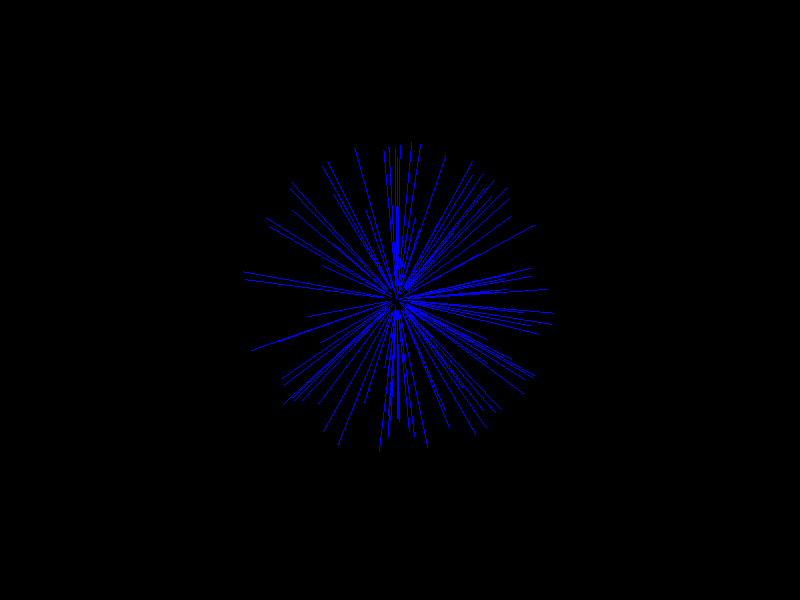

In [655]:
ray_oris, ray_dirs = generate_sphere_rays(cp.array([0,0,0]), 1, 100)
ray_length = 100
endpoints = ray_oris + ray_dirs * ray_length

segments = cp.stack((ray_oris, endpoints), axis=1).reshape(-1, 3)

# Convert to NumPy arrays for Vispy
vertices = cp.asnumpy(segments)
canvas = scene.SceneCanvas(keys='interactive', show=True)
view = canvas.central_widget.add_view()

line = scene.visuals.Line(pos=vertices, color='blue', width=1, connect='segments', parent=view.scene)

view.camera = 'turntable'
view.camera.fov = 45
app.run()
display(canvas.native)

## Ray generation logic - box

## Ray intersection logic

In [656]:
def get_intersection_masks(ray_oris, ray_dirs, boxes):
    n_boxes = boxes.shape[0]
    n_rays = ray_oris.shape[0]
    
    box_min = cp.min(boxes, axis=1)
    box_max = cp.max(boxes, axis=1)  
    box_min = box_min[None, :, :]  # (1, n, 3)
    box_max = box_max[None, :, :]  # (1, n, 3)
    ray_origins = ray_oris[:, None, :]  # (r, 1, 3)~
    ray_directions = ray_dirs[:, None, :]  # (r, 1, 3)
    epsilon = 1e-8
    ray_directions = cp.where(cp.abs(ray_directions) < epsilon, epsilon, ray_directions)
    
    t1 = (box_min - ray_origins) / ray_directions  # (r, n, 3)
    t2 = (box_max - ray_origins) / ray_directions  # (r, n, 3)
    
    t_near = cp.minimum(t1, t2)  # (r, n, 3)
    t_far = cp.maximum(t1, t2)  # (r, n, 3)
    
    # 5. Find the largest t_near and smallest t_far.
    t_near_max = cp.max(t_near, axis=2)  # (r, n)
    t_far_min = cp.min(t_far, axis=2)  # (r, n)
    
    intersection_mask = (t_far_min >= 0) & (t_near_max <= t_far_min)
    return intersection_mask

## Ray intersection logic - visualisation

(1, 17121)


RFBOutputContext()

CanvasBackend(css_height='600px', css_width='800px')
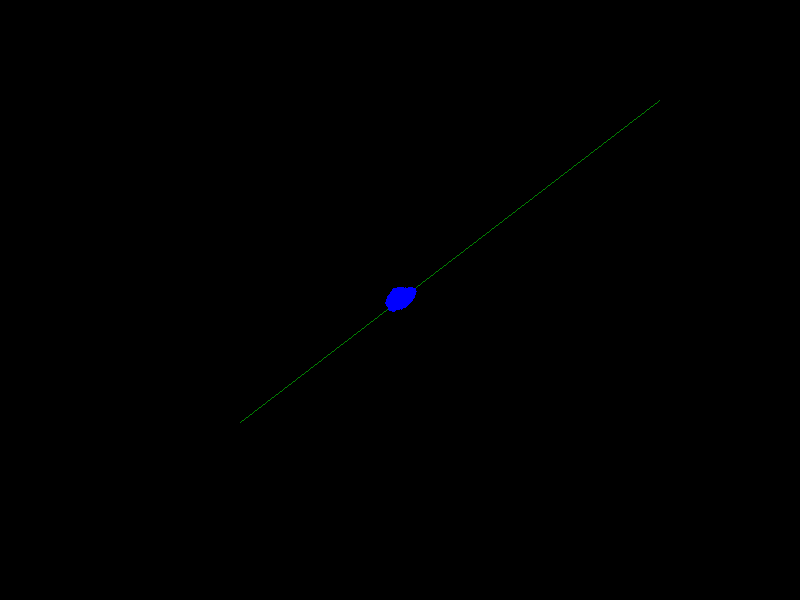

In [657]:
ray_oris = cp.array([[3,3,3]])
ray_dirs = cp.array([[-1, -1, -1]])
intersection_mask = get_intersection_masks(ray_oris, ray_dirs, boxes)
print(intersection_mask.shape)
edges = np.array([
    [0, 1],
    [0, 2],
    [0, 4],
    [1, 3],
    [1, 5],
    [2, 3],
    [2, 6],
    [3, 7],
    [4, 5],
    [4, 6],
    [5, 7],
    [6, 7]
])


boxes_intersected = boxes[intersection_mask[0]]
boxes_np = cp.asnumpy(boxes_intersected)  
segments = boxes_np[:, edges, :]
segments = segments.reshape(-1, 2, 3)  
vertices = segments.reshape(-1, 3) 

canvas = scene.SceneCanvas(keys='interactive', show=True)
view = canvas.central_widget.add_view()

line_visual = scene.visuals.Line(pos=vertices, color='blue', width=2, connect='segments')
view.add(line_visual)

ray_length = 5
endpoints = ray_oris + ray_dirs * ray_length

r_segments = cp.stack((ray_oris, endpoints), axis=1).reshape(-1, 3)
r_vertices = cp.asnumpy(r_segments)

line = scene.visuals.Line(pos=r_vertices, color='green', width=1, connect='segments', parent=view.scene)
view.add(line)

view.camera = 'turntable'
view.camera.fov = 45
view.camera.center = (0,0,0)

app.run()
display(canvas.native)

## Contribution calculation logic

### Evaluate gaussians

In [658]:
from vispy.color import Colormap

def evaluate_gaussians2(point, gaussians):
    # point is shape (3,) and gaussians has attributes:
    #   means: shape (n, 3)
    #   covariances: shape (n, 3, 3)
    #   opacities: shape (n,)
    result_batches = []
    batch_size = int(gaussians.n_gaussians)
    n = gaussians.means.shape[0]
    for i in range(0, n, batch_size):
        batch_means = gaussians.means[i:i+batch_size]      # shape (b, 3)
        batch_covs  = gaussians.covariances[i:i+batch_size]  # shape (b, 3, 3)
        batch_inv_covs = gaussians.inv_covariances[i:i+batch_size]
        batch_rotations = gaussians.rotations[i:i+batch_size]
        batch_scales_d = gaussians.scales_d[i:i+batch_size]
        batch_opacities = gaussians.opacities[i:i+batch_size]
        
        diff = point - batch_means
        exponent = diff[:, None, :] @ (batch_inv_covs @ diff[..., None])
        exponent = exponent.squeeze(-1)
        exponent *= -0.5
        value = cp.exp(exponent)
        value = cp.where(value < 0.5, 0, value)
        result_batches.append(value)
     
    result = cp.concatenate(result_batches)
    return result.flatten()


In [659]:
def evaluate_gaussians(point, gaussians):
    result_batches = []
    batch_size = int(gaussians.n_gaussians)
    n = gaussians.means.shape[0]
    
    for i in range(0, n, batch_size):
        batch_means = gaussians.means[i:i+batch_size]
        batch_covs = gaussians.covariances[i:i+batch_size]
        batch_inv_covs = gaussians.inv_covariances[i:i+batch_size]
        batch_opacities = gaussians.opacities[i:i+batch_size]
        
        diff = (point - batch_means)[..., None]  # shape: (b, 3, 1)
        # Properly compute the quadratic form (x-μ)ᵀΣ⁻¹(x-μ)
        exponent = diff.transpose(0,2,1) @ batch_inv_covs @ diff
        # Compute full Gaussian PDF
        value = cp.exp(-0.5 * exponent)
        result_batches.append(value)
    
    result = cp.concatenate(result_batches)
    return result.flatten()


In [660]:
def visualise_gaussian_evaluations(gaussians, index=0, num_points=30):
    selected_gaussian = gaussians.at(index)
    
    boxes = create_bounding_boxes(gaussians)
    selected_box = boxes[index]
    start = cp.array([cp.min(selected_box[:,0]),
                      cp.min(selected_box[:,1]),
                      cp.min(selected_box[:,2])])
    end = cp.array([cp.max(selected_box[:,0]),
                    cp.max(selected_box[:,1]),
                    cp.max(selected_box[:,2])])
    
    # Create a denser grid for better visualization
    x = cp.linspace(start[0], end[0], num=num_points)
    y = cp.linspace(start[1], end[1], num=num_points)
    
    # Create 2D grid at mean z-level
    mean_z = selected_gaussian.means[0, 2]
    X, Y = cp.meshgrid(x, y)
    grid_points = cp.stack([X.ravel(), Y.ravel(), 
                          cp.full_like(X.ravel(), mean_z)], axis=1)
    
    values = cp.array([evaluate_gaussians(point, selected_gaussian) 
                      for point in grid_points])
    
    # Reshape values back to grid
    values = values.reshape(num_points, num_points)
    
    # Create visualization
    canvas = scene.SceneCanvas(keys='interactive', show=True)
    view = canvas.central_widget.add_view()
    
    # Create color-mapped image
    cmap = Colormap(['blue', 'green', 'yellow', 'red'])
    # norm_values = (values - values.min()) / (values.max() - values.min())
    
    # Create and add image
    image = scene.visuals.Image(values.get(), cmap=cmap)
    view.add(image)
    
    # Set camera
    view.camera = scene.PanZoomCamera(aspect=1)
    view.camera.set_range()
    
    display(canvas.native)


def debug_gaussian_values(gaussians, index=0):
    g = gaussians.at(index)
    print("Quaternion:", g.quaternions[0].get())
    print("Rotation matrix:\n", g.rotations[0].get())
    print("Scales (raw):", g.scales[0].get())
    print("Scales (exp):", g.scales_exp[0].get())
    print("Covariance matrix:\n", g.covariances[0].get())
    
    # Let's also verify the calculation steps
    print("\nVerification steps:")
    rot = g.rotations[0]
    scale_d = g.scales_d[0]
    print("Scale diagonal matrix:\n", scale_d.get())
    temp = cp.matmul(scale_d, g.rotations_t[0])
    print("Scale * R^T:\n", temp.get())
    final = cp.matmul(g.rotations[0], temp)
    print("Final covariance (step by step):\n", final.get())
visualise_gaussian_evaluations(gaussians, -6)
debug_gaussian_values(gaussians, -6)

hell


AttributeError: 'Gaussians' object has no attribute 'n_gaussians'

In [ ]:
import numpy as np
import cupy as cp
from vispy import scene, app

def evaluate_pdf_3d(x, mean, cov_inv, opacity):
    """
    Evaluate the multivariate Gaussian PDF at point(s) x.
    x: shape (N, 3)
    mean: shape (3,)
    cov_inv: inverse of covariance (3,3)
    norm_const: normalization constant = 1/sqrt((2π)^3 * det(cov))
    """
    diff = (x - mean)[..., None]  # shape: (b, 3, 1)
    cov_invs = np.tile(cov_inv, (x.shape[0],1,1))

    exponent = diff.transpose(0,2,1) @ cov_invs @ diff
    # Compute full Gaussian PDF
    value = np.exp(-0.5 * exponent)
    value = np.where(value < 0.8, 0, value)
    value *= opacity
    print(opacity)
    return value
    
def visualise_gaussian_pdf_3d(gaussians, index=0, num_points=50):
    # Retrieve the selected Gaussian model (using your at() method)
    selected = gaussians.at(index)

    # Convert mean and covariance from cupy to numpy for evaluation
    mean = selected.means.get()[0]  # shape (3,)
    cov = selected.covariances.get()[0]  # shape (3,3)
    opacity = selected.opacities[0].get()

    box = create_bounding_boxes(gaussians)[index]
    enbiggen = 0
    lower_x = cp.min(box[:,0]) - enbiggen
    lower_y = cp.min(box[:, 1]) - enbiggen
    lower_z = cp.min(box[:, 2]) - enbiggen

    upper_x = cp.max(box[:, 0]) + enbiggen
    upper_y = cp.max(box[:, 1]) + enbiggen
    upper_z = cp.max(box[:, 2]) + enbiggen

    lower = np.array([lower_x.get(), lower_y.get(), lower_z.get()])
    upper = np.array([upper_x.get(), upper_y.get(), upper_z.get()])

    # Create a 3D grid over this bounding box
    xs = np.linspace(lower[0], upper[0], num_points)
    ys = np.linspace(lower[1], upper[1], num_points)
    zs = np.linspace(lower[2], upper[2], num_points)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing='ij')
    grid_points = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    # Pre-compute covariance inverse and determinant
    cov_inv = np.linalg.inv(cov)

    # Evaluate the PDF over the grid
    pdf_vals = evaluate_pdf_3d(grid_points, mean, cov_inv, opacity)
    volume_data = pdf_vals.reshape(num_points, num_points, num_points)

    # Set up Vispy scene with volume rendering
    canvas = scene.SceneCanvas(keys='interactive', show=True, bgcolor='black')
    view = canvas.central_widget.add_view()
    
    # Create the Volume visual; you can adjust the threshold and cmap as needed.
    vol = scene.visuals.Volume(volume_data, parent=view.scene, threshold=volume_data.max()*0.05, cmap='viridis')
    
    # Use a TurntableCamera to rotate and inspect the volume
    view.camera = scene.cameras.TurntableCamera(fov=60, distance=10)
    view.camera.set_range()
    display(canvas.native)
    app.run()
visualise_gaussian_pdf_3d(gaussians, -10)
debug_gaussian_values(gaussians, -10)

###  Given a set of GSs and a ray, find the point along the ray which yields the maximum value per GS

In [ ]:
from vispy.scene import visuals
def get_max_positions(ray_ori, ray_dir, gaussians):
    inv_covs = cp.linalg.inv(gaussians.covariances)

    dx_t = gaussians.means - ray_ori
    numerators =  cp.tile(ray_dir, (gaussians.n_gaussians, 1))[:,None,:] @ (inv_covs @ dx_t[..., None])

    denomenators = cp.tile(ray_dir, (gaussians.n_gaussians, 1))[:,None,:] @ inv_covs @ cp.tile(ray_dir, (gaussians.n_gaussians, 1))[..., None]
    t_values = numerators / denomenators
    points = ray_ori + t_values * ray_dir
    return points.squeeze()

def visualise_max_positions(ray_ori, ray_dir, gaussians):
    positions = cp.asnumpy(get_max_positions(ray_ori, ray_dir, gaussians))
    means = cp.asnumpy(gaussians.means)
    positions = cp.asnumpy(positions)

    # Create a vispy SceneCanvas with an interactive view.
    canvas = scene.SceneCanvas(keys='interactive', bgcolor='black', size=(800, 600), show=True)
    view = canvas.central_widget.add_view()
    
    # Set up a turntable camera with a field-of-view of 45 degrees.
    view.camera = scene.cameras.TurntableCamera(fov=45, distance=10)

    # Build an array of segments: each segment connects a Gaussian mean to its max position.
    # The segments array will have shape (2*N, 3) with consecutive pairs forming a line.
    N = means.shape[0]
    segments = np.empty((N * 2, 3), dtype=np.float32)
    segments[0::2] = means       # Start points (Gaussian means)
    segments[1::2] = positions   # End points (max positions)

    # Create a line visual using the segments. The "connect='segments'" argument ensures that
    # each pair of points is treated as an individual segment.
    line = scene.visuals.Line(pos=segments, color='white', width=2, connect='segments')
    view.add(line)

    # Optionally, add scatter visuals for clarity: red for means and green for max positions.
    scatter_means = scene.visuals.Markers()
    scatter_means.set_data(means, face_color='red', size=8)
    view.add(scatter_means)
    
    scatter_positions = scene.visuals.Markers()
    scatter_positions.set_data(positions, face_color='green', size=8)
    view.add(scatter_positions)

    # Start the application event loop.
    app.run()
    display(canvas.native)
    
ray_ori = cp.array([ 43.2037912,-29.85525533,-85.10050619])
ray_dir = cp.array([ 0.13662238,-0.09441061,-0.26911143])
visualise_max_positions(ray_ori, ray_dir, gaussians)

### argmax(GS(ray_ori, ray_dir)) logic

In [ ]:
from tqdm import trange

def get_max_gaussians(ray_ori, ray_dir, gaussians):
    points = get_max_positions(ray_ori, ray_dir, gaussians)
    values = cp.zeros(gaussians.n_gaussians)
    for i in trange(len(points)):
        values += evaluate_gaussians(points[i], gaussians)
    return values

In [ ]:
def get_contributions(ray_ori, ray_dir, gaussians, intersection_mask):
    # Compute normalized alphas
    alphas = get_max_gaussians(ray_ori, ray_dir, gaussians).squeeze()
    print("alpha max:", cp.max(alphas))
    alphas = alphas - cp.min(alphas)
    max_val = cp.max(alphas)
    if max_val > 0:
        alphas = alphas / max_val

    # Sort indices based on the z-coordinate of the gaussian means (front-to-back)
    sort_idx = cp.argsort(gaussians.means[:, 2])
    alphas_sorted = alphas[sort_idx]
    
    # Compute transmittance T for each layer:
    # T[0] = 1, and for i > 0, T[i] = prod_{j=0}^{i-1} (1 - alpha_sorted[j])
    T = cp.ones_like(alphas_sorted)
    if alphas_sorted.shape[0] > 1:
        # Compute cumulative product of (1 - alphas) for all but the last layer,
        # then shift it to get T for each layer.
        T[1:] = cp.cumprod(1 - alphas_sorted[:-1])
    
    # The gaussian's contribution is then:
    contributions = alphas_sorted * T
    print(cp.max(contributions))
    return contributions
    
average_contribution = cp.zeros((gaussians.n_gaussians, 1))
ray_oris, ray_dirs = generate_sphere_rays(cp.array([0,0,0]), 100, 10)
intersection_masks = get_intersection_masks(ray_oris, ray_dirs, boxes)
for i in range(ray_oris.shape[0]):
    ray_ori = ray_oris[i]
    ray_dir = ray_dirs[i]
    print("ray ori: ", ray_ori)
    print("ray dir: ", ray_dir)
    intersection_mask = intersection_masks[i].reshape(gaussians.n_gaussians, 1)
    contributions = get_contributions(ray_ori, ray_dir, gaussians, intersection_mask).reshape(gaussians.n_gaussians, 1)
    average_contribution += contributions

In [ ]:
plt.plot(average_contribution.get())
print(cp.max(average_contribution))

In [ ]:
from vispy.color import get_colormap

def visualize_contributions(ray_ori, ray_dir, gaussians, contributions):

    ray_ori = cp.asnumpy(ray_ori)
    ray_dir = cp.asnumpy(ray_dir)
    centers = cp.asnumpy(gaussians.means)  # assuming shape (n_gaussians, 3)
    contributions = cp.asnumpy(contributions).flatten()  # ensure a 1D array
    canvas = scene.SceneCanvas(keys='interactive', size=(800, 600), show=True)
    view = canvas.central_widget.add_view()
    view.camera = 'turntable'  # enables mouse-driven 3D rotation

    # --- Draw the original ray ---
    # Here we choose an arbitrary length for visualization
    ray_length = 10.0
    ray_end = ray_ori + ray_dir * ray_length
    ray_positions = np.array([ray_ori, ray_end])
    ray_line = scene.visuals.Line(pos=ray_positions, color='red', width=2)
    view.add(ray_line)

    # --- Normalize contributions ---
    # Avoid division by zero if contributions are constant.
    contrib_min = contributions.min()
  
    contrib_max = contributions.max()
    norm_contrib = (contributions - contrib_min) / (contrib_max - contrib_min + 1e-8)
    # --- Map normalized contributions to colors using a colormap ---
    cmap = get_colormap('viridis')
    colors = cmap.map(norm_contrib)
    # --- Create a marker for each mean ---
    markers = scene.visuals.Markers()
    markers.set_data(centers, face_color=colors, size=10)
    view.add(markers)
    
    # Start the Vispy app event loop
    app.run()
    display(canvas.native)
visualise_gaussian_evaluations(gaussians, average_contribution, ray_ori)

## Surface GS extraction logic

## FEM-GS visualisation logic

## 

In [ ]:
def visualise_all_gaussian_pdf_3d(gaussians, canvas, view, num_points=50):
    # Compute global bounding box by aggregating all individual boxes.
    boxes = create_bounding_boxes(gaussians)  # shape (N, 8, 3)
    lower_x = cp.min(boxes[:, :, 0])
    lower_y = cp.min(boxes[:, :, 1])
    lower_z = cp.min(boxes[:, :, 2])
    upper_x = cp.max(boxes[:, :, 0])
    upper_y = cp.max(boxes[:, :, 1])
    upper_z = cp.max(boxes[:, :, 2])
    
    lower = np.array([lower_x.get(), lower_y.get(), lower_z.get()])
    upper = np.array([upper_x.get(), upper_y.get(), upper_z.get()])

    # Create a 3D grid over the global bounding box.
    xs = np.linspace(lower[0], upper[0], num_points)
    ys = np.linspace(lower[1], upper[1], num_points)
    zs = np.linspace(lower[2], upper[2], num_points)
    X, Y, Z = np.meshgrid(xs, ys, zs, indexing='ij')
    grid_points = np.stack([X.ravel(), Y.ravel(), Z.ravel()], axis=1)

    # Initialize volume data.
    volume_data = np.zeros(grid_points.shape[0], dtype=np.float32)
    test_gaussians.opacities = cp.array(
            [0.0, 0.5, 1.0, 1.0]
    )
    # For each Gaussian, evaluate its PDF over the grid and sum up the densities.
    N = gaussians.means.shape[0]
    for i in range(N):
        selected = gaussians.at(i)
        mean = selected.means.get()[0]       # shape (3,)
        print(selected.covariances)
        cov = selected.covariances.get()[0]    # shape (3,3)
        cov_inv = np.linalg.inv(cov)
        opacity = selected.opacities.get()[0]
      
        # Evaluate the PDF for this Gaussian over the grid.
        pdf_vals = evaluate_pdf_3d(grid_points, mean, cov_inv, opacity)
        pdf_vals = pdf_vals.reshape(-1)
        volume_data += pdf_vals

    volume_data = volume_data.reshape(num_points, num_points, num_points)

    vol = scene.visuals.Volume(volume_data, parent=view.scene,
                               cmap='hot')
    


In [661]:
def create_test_gaussians():
    test_gaussians = Gaussians(None)
    test_gaussians.means = cp.array(
        [
            [0,0,1],
            [0,0,4],
            [0,0,7],
            [0,0,10]
        ]
    )
    test_gaussians.opacities = cp.array(
        [0.0, 0.5, 1.0, 1.0]
    )
    test_gaussians.opacities = test_gaussians.opacities[..., None]
    test_gaussians.scales = cp.random.rand(4,3)
    test_gaussians.quaternions = cp.random.rand(4,4)
    test_gaussians.post_process()
   
    return test_gaussians
    
test_gaussians = create_test_gaussians()


In [662]:
def add_ray_to_canvas(canvas, view, ray_ori, ray_dir, distance=30.0, color='red', width=2):
    # Ensure inputs are numpy arrays
    ray_ori = ray_ori.get()
    ray_dir = ray_dir.get()
    # Normalize the ray direction
    ray_dir = ray_dir / np.linalg.norm(ray_dir)
    
    # Compute the endpoint of the ray
    ray_end = ray_ori + ray_dir * distance
    
    # Stack the origin and endpoint to form the ray line points
    ray_points = np.vstack([ray_ori, ray_end])
    
    # Create a line visual for the ray
    ray_line = scene.visuals.Line(pos=ray_points, color=color, width=width)
    
    view.add(ray_line)
    return ray_line

### Call it

RFBOutputContext()

hell
[[[ 5.00826082 -0.33731814  1.70907541]
  [-0.33731814  1.73708159 -0.11072284]
  [ 1.70907541 -0.11072284  2.49780066]]]
0.0
hell
[[[ 2.44524038 -0.46544072 -0.46495224]
  [-0.46544072  1.90753749  0.23454065]
  [-0.46495224  0.23454065  3.36460573]]]
0.5
hell
[[[ 5.4002218  -0.26464981  0.43501939]
  [-0.26464981  5.18727439  0.14476621]
  [ 0.43501939  0.14476621  5.78835182]]]
1.0
hell
[[[ 3.76542047 -1.27122869 -0.5325153 ]
  [-1.27122869  3.89150357  0.5195317 ]
  [-0.5325153   0.5195317   2.83886445]]]
1.0


CanvasBackend(css_height='600px', css_width='800px')
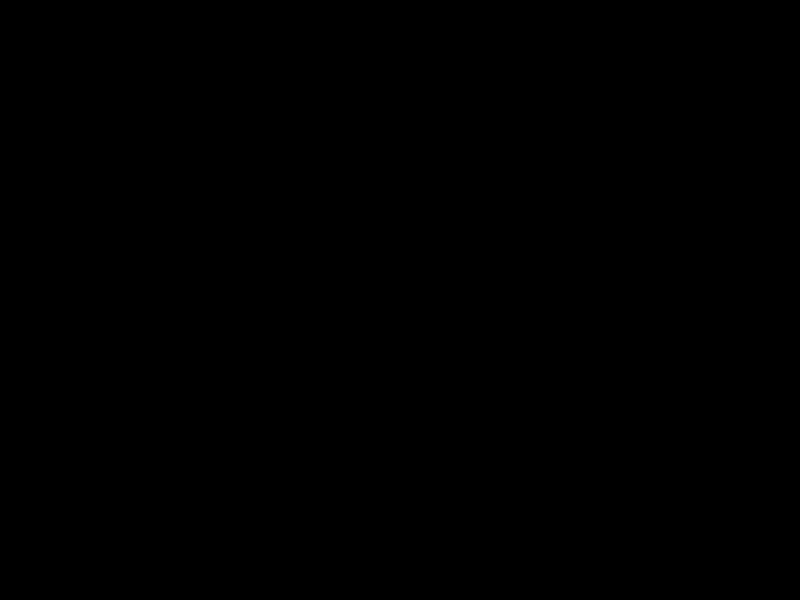

In [663]:
canvas = scene.SceneCanvas(keys='interactive', show=True, bgcolor='black')
view = canvas.central_widget.add_view()
# Configure the camera for this view.
view.camera = scene.cameras.TurntableCamera(fov=60, distance=10)
view.camera.set_range()
add_ray_to_canvas(canvas, view, cp.array([0,0,0]), cp.array([1,1,1]))
visualise_all_gaussian_pdf_3d(test_gaussians, canvas, view)
display(canvas.native)

In [755]:
import cupy as cp
import numpy as np  # For any CPU-side operations if needed
from cupyx.scipy.special import erf
def batch_integrate_gaussians_on_rays(ray_ori, ray_dirs, gaussians, t_min=-cp.inf, t_max=cp.inf):
    """
    Batched closed-form integration of multiple Gaussians along multiple rays.
    
    Parameters:
      ray_ori: cp.ndarray of shape (r, 3)
          Ray origins.
      ray_dirs: cp.ndarray of shape (r, 3)
          Ray directions (need not be normalized; they will be normalized).
      gaussians: Gaussians object containing attributes:
          - means: shape (n, 3)
          - inv_covariances: shape (n, 3, 3)
          - opacities: shape (n,) or (n, 1)
      t_min: scalar (default -cp.inf)
          Lower integration limit along the ray.
      t_max: scalar (default cp.inf)
          Upper integration limit along the ray.
    
    Returns:
      I: cp.ndarray of shape (r, n)
          The closed-form integral of each Gaussian along each ray.
    """
    # Normalize the ray directions (r,3)
    ray_dirs = ray_dirs / cp.linalg.norm(ray_dirs, axis=1, keepdims=True)  # (r, 3)
    
    # Retrieve Gaussian parameters.
    # means: (n,3), inv_covariances: (n,3,3)
    means = gaussians.means       # (n, 3)
    Sigma_inv = gaussians.inv_covariances  # (n, 3, 3)
    
    # Number of rays and Gaussians.
    r = ray_ori.shape[0]
    n = means.shape[0]
    
    # Compute v = d^T Sigma_inv d for each ray and Gaussian.
    # Result: (r, n)
    v = cp.einsum('ri, nij, rj -> rn', ray_dirs, Sigma_inv, ray_dirs)
    
    # Compute diff = ray_ori - mu for each ray and Gaussian.
    # Result: (r, n, 3)
    diff = ray_ori[:, None, :] - means[None, :, :]
    
    # Compute w = d^T Sigma_inv (ray_ori - mu)
    # (r, n) = sum_{i,j} ray_dirs[r,i] * Sigma_inv[n,i,j] * diff[r,n,j]
    w = cp.einsum('ri, nij, rnj -> rn', ray_dirs, Sigma_inv, diff)
    
    # Compute c = (ray_ori - mu)^T Sigma_inv (ray_ori - mu)
    # Result: (r, n)
    c = cp.einsum('rni, nij, rnj -> rn', diff, Sigma_inv, diff)
    
    # For numerical stability, ensure v is not zero.
    # (In practice v > 0 since Sigma_inv is positive definite.)
    
    # Compute scaling factors.
    sqrt_v_over_2 = cp.sqrt(v / 2.0)  # (r, n)
    
    # Compute the transformed integration limits.
    # Here, u = sqrt(v/2)*(t + w/v)
    # Note: w/v is computed elementwise.
    u_max = sqrt_v_over_2 * (t_max + w / v)  # (r, n)
    u_min = sqrt_v_over_2 * (t_min + w / v)  # (r, n)
    
    # Difference of error functions.
    erf_diff = erf(u_max) - erf(u_min)  # (r, n)
    
    # Compute the prefactor: sqrt(2*pi)/(2*sqrt(v))
    prefactor = cp.sqrt(2 * cp.pi) / (2 * cp.sqrt(v))  # (r, n)
    
    # Exponential factor: exp(w^2/(2v) - c/2)
    exp_factor = cp.exp((w**2) / (2 * v) - c / 2)  # (r, n)
    
    # Closed-form integral along each ray for each Gaussian.
    I = prefactor * exp_factor * erf_diff  # (r, n)
    
    # Modulate by the Gaussian opacities.
    # Reshape opacities to broadcast correctly: (n,) -> (1, n)
    opacity = gaussians.opacities.reshape(1, -1)
    I = I * opacity  # (r, n)
    
    return I
ray_oris, ray_dirs = generate_sphere_rays(cp.array([0,0,0]), 0.5, 1000)
I = batch_integrate_gaussians_on_rays(ray_oris, ray_dirs, gaussians)

In [756]:
print(cp.min(I))

0.0


In [757]:
import cupy as cp

def aggregate_and_minmax_normalize(I):
    """
    Given a dense integration result I of shape (r, n) where each entry corresponds
    to the integrated contribution of a Gaussian along a ray, this function computes:
      1. The mean contribution per Gaussian (aggregated over all rays).
      2. A min-max normalized version of that vector such that the minimum value is 0
         and the maximum value is 1.
    
    Parameters:
        I: cp.ndarray of shape (r, n)
            The dense integration results.
    
    Returns:
        normalized: cp.ndarray of shape (n,)
            The min-max normalized mean contributions per Gaussian.
    """
    # Aggregate: average contribution per Gaussian over the rays.
    mean_contrib = cp.mean(I, axis=0)  # shape (n,)
    
    # Compute the minimum and maximum of the aggregated contributions.
    min_val = cp.min(mean_contrib)
    max_val = cp.max(mean_contrib)
    
    # Apply min-max normalization to map values to [0, 1]
    normalized = (mean_contrib - min_val) / (max_val - min_val)
    
    return normalized

standardized_values = aggregate_and_minmax_normalize(I)

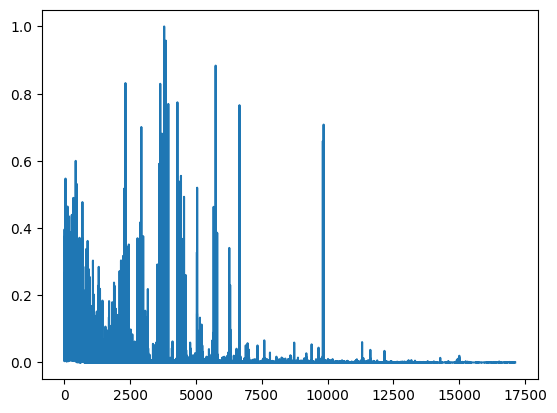

In [758]:
plt.plot(standardized_values.get())

In [759]:
def render_ray_oris(canvas, view, ray_oris, marker_size=5):
    """
    Renders the given ray origins as red markers on the provided Vispy view.
    
    Parameters:
      canvas: vispy.scene.SceneCanvas
          The Vispy canvas.
      view: vispy.scene.widgets.ViewBox or similar
          The view in which to render the markers.
      ray_oris: cp.ndarray of shape (r, 3)
          The ray origin points.
      marker_size: int (default 5)
          Size of the markers.
    """
    # Convert the CuPy array to a NumPy array for rendering.
    ray_oris_np = cp.asnumpy(ray_oris)
    
    # Create a markers visual and set its data.
    markers = scene.visuals.Markers()
    markers.set_data(ray_oris_np, face_color='red', size=marker_size)
    
    # Add the markers to the view.
    view.add(markers)
    
    # Optionally update or refresh the canvas.
    canvas.update()

In [765]:
means_np = cp.asnumpy(gaussians.means)  # Convert to NumPy array
values_np = cp.asnumpy(I).flatten()  # Convert and flatten to 1D array

# Create a canvas with a 3D viewport
canvas = scene.SceneCanvas(keys='interactive', show=True)
view = canvas.central_widget.add_view()
view.camera = 'turntable'  # 3D camera

# Normalize values to a suitable size range for visualization
min_size = 5  # Minimum marker size
max_size = 10  # Maximum marker size
norm_values = (values_np - values_np.min()) / (values_np.ptp() + np.finfo(float).eps)
sizes = min_size + norm_values * (max_size - min_size)

# Create the scatter plot
scatter = visuals.Markers()
scatter.set_data(means_np, size=sizes, edge_color=None, face_color='white')

# Add the scatter plot to the view
view.add(scatter)
render_ray_oris(canvas, view, ray_oris)
display(canvas.native)

RFBOutputContext()

ValueError: could not broadcast input array from shape (17121000,) into shape (17121,)